# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-05-31 06:13:44--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  37.8MB/s    in 5.3s    

2021-05-31 06:13:49 (32.6 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-05-31 06:13:49--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  39.4MB/s    in 1.6s    

2021-05-31 06:13:51 (39.4 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-05-31 06:13:51--
Total wall clock time: 7.1s
Downloaded: 2 files, 235M i

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [4]:
device

device(type='cuda', index=0)

# Загружаем данные

In [5]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [8]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [9]:
def compute_val_loss(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    loss_accum = 0
    
    for x, y in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        preds = model(x_gpu)
        loss_accum += float(loss(preds, y_gpu))
        
    return loss_accum


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, sheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if epoch % 5 == 0:
            print(f'epoch number {epoch}')
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        val_loss = compute_val_loss(model, val_loader)

        if sheduler is not None:
            if isinstance(sheduler, optim.lr_scheduler.ReduceLROnPlateau):
                sheduler.step(val_loss)
            else:
                sheduler.step()

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() 
    # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    correct_samples = 0
    total_samples = 0
    
    for x, y in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)

        preds = model(x_gpu)
        _, indices = torch.max(preds, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
    
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

epoch number 0
Average loss: 1.424487, Train accuracy: 0.522404, Val accuracy: 0.735376
Average loss: 0.687619, Train accuracy: 0.791762, Val accuracy: 0.799331
Average loss: 0.583968, Train accuracy: 0.826195, Val accuracy: 0.817828
Average loss: 0.537634, Train accuracy: 0.840204, Val accuracy: 0.816258
Average loss: 0.513988, Train accuracy: 0.847371, Val accuracy: 0.841513


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [10]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


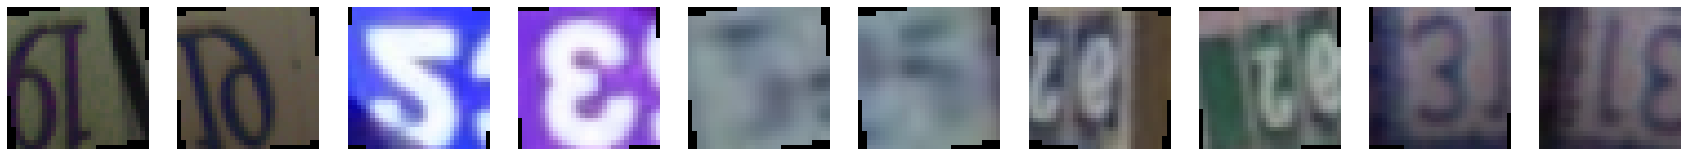

In [11]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [12]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [13]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

epoch number 0
Average loss: 1.001039, Train accuracy: 0.671433, Val accuracy: 0.747799
Average loss: 0.843871, Train accuracy: 0.726769, Val accuracy: 0.777899
Average loss: 0.798323, Train accuracy: 0.743542, Val accuracy: 0.786363
Average loss: 0.767177, Train accuracy: 0.753455, Val accuracy: 0.772985
Average loss: 0.743733, Train accuracy: 0.762140, Val accuracy: 0.772302


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [14]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(in_channels=3, kernel_size=5, out_channels=6, stride=1),
    nn.Tanh(),

    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=6, kernel_size=5, out_channels=16),
    nn.Tanh(),

    nn.MaxPool2d(2),

    nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
    nn.Tanh(),

    nn.Flatten(),

    nn.Linear(in_features=120, out_features=10),
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [15]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

epoch number 0
Average loss: 1.332580, Train accuracy: 0.549534, Val accuracy: 0.752099
Average loss: 0.775760, Train accuracy: 0.753472, Val accuracy: 0.784929
Average loss: 0.676480, Train accuracy: 0.785551, Val accuracy: 0.801106
Average loss: 0.616508, Train accuracy: 0.807341, Val accuracy: 0.824312
Average loss: 0.581721, Train accuracy: 0.820496, Val accuracy: 0.828749
epoch number 5
Average loss: 0.554805, Train accuracy: 0.826127, Val accuracy: 0.810388
Average loss: 0.536220, Train accuracy: 0.831775, Val accuracy: 0.836530
Average loss: 0.518306, Train accuracy: 0.838481, Val accuracy: 0.837349
Average loss: 0.507587, Train accuracy: 0.842422, Val accuracy: 0.838100
Average loss: 0.495398, Train accuracy: 0.847336, Val accuracy: 0.838919


# Подбор гиперпараметров

In [16]:
import itertools
import random

from scipy.stats import uniform, norm, expon, randint

In [17]:
def create_params(grid, n_iter):
    params = []
    for i in range(n_iter):
        param = []
        for key, value in grid.items():
            if isinstance(value, list):
                param.append(random.choice(value))
            else:
                param.append(value.rvs())
        params.append(param)
    return params

In [18]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

grid_of_params = {
    'learning_rates': uniform(1e-6, 1e-3),
    # 'anneal_coeff': uniform(0, 0.3),
    'anneal_epochs': randint(2, 7),
    'reg': uniform(1e-6, 1e-2),
}

In [19]:
from tqdm import tqdm

for lr, anneal_ap, r_str in tqdm(create_params(grid_of_params, n_iter=10)):
    param = Hyperparams(lr, anneal_ap, r_str)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(lenet_model.parameters(), lr=lr, weight_decay=r_str)
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=anneal_ap)

    run_record[param] = RunResult(lenet_model, *train_model(lenet_model, 
                                                            train_aug_loader, 
                                                            val_loader, 
                                                            loss, 
                                                            optimizer, 
                                                            10, 
                                                            sheduler=sheduler))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch number 0
Average loss: 0.445124, Train accuracy: 0.862744, Val accuracy: 0.862535
Average loss: 0.443538, Train accuracy: 0.865423, Val accuracy: 0.862262
Average loss: 0.442069, Train accuracy: 0.866191, Val accuracy: 0.862535
Average loss: 0.446507, Train accuracy: 0.866276, Val accuracy: 0.859054
Average loss: 0.448970, Train accuracy: 0.864997, Val accuracy: 0.863559
epoch number 5
Average loss: 0.447524, Train accuracy: 0.866072, Val accuracy: 0.864037
Average loss: 0.447723, Train accuracy: 0.866379, Val accuracy: 0.862808
Average loss: 0.452734, Train accuracy: 0.865338, Val accuracy: 0.864105
Average loss: 0.449881, Train accuracy: 0.866328, Val accuracy: 0.860010


 10%|█         | 1/10 [07:46<1:10:01, 466.80s/it]

Average loss: 0.436680, Train accuracy: 0.870372, Val accuracy: 0.867995
epoch number 0
Average loss: 0.434406, Train accuracy: 0.872487, Val accuracy: 0.867654
Average loss: 0.438255, Train accuracy: 0.871634, Val accuracy: 0.867449
Average loss: 0.441736, Train accuracy: 0.871651, Val accuracy: 0.867313
Average loss: 0.446242, Train accuracy: 0.870355, Val accuracy: 0.866767
Average loss: 0.448412, Train accuracy: 0.869928, Val accuracy: 0.867176
epoch number 5
Average loss: 0.450980, Train accuracy: 0.870423, Val accuracy: 0.866767
Average loss: 0.450992, Train accuracy: 0.870781, Val accuracy: 0.865879
Average loss: 0.453352, Train accuracy: 0.870952, Val accuracy: 0.865948
Average loss: 0.453825, Train accuracy: 0.869774, Val accuracy: 0.865606


 20%|██        | 2/10 [15:36<1:02:21, 467.74s/it]

Average loss: 0.453800, Train accuracy: 0.870559, Val accuracy: 0.865675
epoch number 0
Average loss: 0.471238, Train accuracy: 0.865014, Val accuracy: 0.860146
Average loss: 0.492463, Train accuracy: 0.860475, Val accuracy: 0.860214
Average loss: 0.507156, Train accuracy: 0.856721, Val accuracy: 0.858030
Average loss: 0.519492, Train accuracy: 0.854486, Val accuracy: 0.852706
Average loss: 0.531770, Train accuracy: 0.852097, Val accuracy: 0.853662
epoch number 5
Average loss: 0.532336, Train accuracy: 0.851636, Val accuracy: 0.853730
Average loss: 0.532106, Train accuracy: 0.849930, Val accuracy: 0.853730
Average loss: 0.532098, Train accuracy: 0.850664, Val accuracy: 0.853457
Average loss: 0.534006, Train accuracy: 0.851380, Val accuracy: 0.853594


 30%|███       | 3/10 [23:22<54:30, 467.16s/it]  

Average loss: 0.531345, Train accuracy: 0.852268, Val accuracy: 0.853594
epoch number 0
Average loss: 0.607117, Train accuracy: 0.823789, Val accuracy: 0.834073
Average loss: 0.633571, Train accuracy: 0.814882, Val accuracy: 0.822811
Average loss: 0.645692, Train accuracy: 0.810583, Val accuracy: 0.824312
Average loss: 0.646775, Train accuracy: 0.810685, Val accuracy: 0.819876
Average loss: 0.648496, Train accuracy: 0.810105, Val accuracy: 0.815849
epoch number 5
Average loss: 0.651445, Train accuracy: 0.808450, Val accuracy: 0.820149
Average loss: 0.650278, Train accuracy: 0.809559, Val accuracy: 0.818442
Average loss: 0.613600, Train accuracy: 0.823550, Val accuracy: 0.834960
Average loss: 0.606523, Train accuracy: 0.828294, Val accuracy: 0.837212


 40%|████      | 4/10 [31:09<46:42, 467.08s/it]

Average loss: 0.605264, Train accuracy: 0.829761, Val accuracy: 0.837759
epoch number 0
Average loss: 0.617730, Train accuracy: 0.819694, Val accuracy: 0.829227
Average loss: 0.610016, Train accuracy: 0.823568, Val accuracy: 0.836120
Average loss: 0.609729, Train accuracy: 0.824097, Val accuracy: 0.837690
Average loss: 0.608350, Train accuracy: 0.824370, Val accuracy: 0.831820
Average loss: 0.607533, Train accuracy: 0.823960, Val accuracy: 0.834892
epoch number 5
Average loss: 0.607294, Train accuracy: 0.822663, Val accuracy: 0.832639
Average loss: 0.606498, Train accuracy: 0.824284, Val accuracy: 0.829909
Average loss: 0.607956, Train accuracy: 0.823107, Val accuracy: 0.829295
Average loss: 0.604328, Train accuracy: 0.824557, Val accuracy: 0.835028


 50%|█████     | 5/10 [38:55<38:53, 466.77s/it]

Average loss: 0.606035, Train accuracy: 0.824864, Val accuracy: 0.833663
epoch number 0
Average loss: 0.589907, Train accuracy: 0.829830, Val accuracy: 0.840147
Average loss: 0.581550, Train accuracy: 0.830836, Val accuracy: 0.839260
Average loss: 0.580918, Train accuracy: 0.832014, Val accuracy: 0.840625
Average loss: 0.578262, Train accuracy: 0.833106, Val accuracy: 0.843492
Average loss: 0.578934, Train accuracy: 0.833464, Val accuracy: 0.840693
epoch number 5
Average loss: 0.578818, Train accuracy: 0.833515, Val accuracy: 0.840557
Average loss: 0.576661, Train accuracy: 0.833601, Val accuracy: 0.841649
Average loss: 0.568067, Train accuracy: 0.837730, Val accuracy: 0.842673
Average loss: 0.566974, Train accuracy: 0.836877, Val accuracy: 0.843560


 60%|██████    | 6/10 [46:37<31:01, 465.35s/it]

Average loss: 0.564981, Train accuracy: 0.839180, Val accuracy: 0.842809
epoch number 0
Average loss: 0.606766, Train accuracy: 0.824131, Val accuracy: 0.832298
Average loss: 0.613624, Train accuracy: 0.822271, Val accuracy: 0.836530
Average loss: 0.614607, Train accuracy: 0.821810, Val accuracy: 0.832025
Average loss: 0.616470, Train accuracy: 0.820496, Val accuracy: 0.831206
Average loss: 0.616149, Train accuracy: 0.822083, Val accuracy: 0.831820
epoch number 5
Average loss: 0.595657, Train accuracy: 0.831127, Val accuracy: 0.839124
Average loss: 0.590960, Train accuracy: 0.832287, Val accuracy: 0.840352
Average loss: 0.589762, Train accuracy: 0.833191, Val accuracy: 0.839806
Average loss: 0.588315, Train accuracy: 0.834198, Val accuracy: 0.839943


 70%|███████   | 7/10 [54:24<23:17, 465.77s/it]

Average loss: 0.590034, Train accuracy: 0.833089, Val accuracy: 0.842059
epoch number 0
Average loss: 0.617747, Train accuracy: 0.815019, Val accuracy: 0.823766
Average loss: 0.604965, Train accuracy: 0.819251, Val accuracy: 0.834960
Average loss: 0.602179, Train accuracy: 0.819882, Val accuracy: 0.839192
Average loss: 0.596021, Train accuracy: 0.823397, Val accuracy: 0.831343
Average loss: 0.592452, Train accuracy: 0.824114, Val accuracy: 0.836120
epoch number 5
Average loss: 0.593502, Train accuracy: 0.823363, Val accuracy: 0.835165
Average loss: 0.593319, Train accuracy: 0.824250, Val accuracy: 0.829227
Average loss: 0.592429, Train accuracy: 0.823909, Val accuracy: 0.835711
Average loss: 0.595844, Train accuracy: 0.822851, Val accuracy: 0.836393


 80%|████████  | 8/10 [1:02:12<15:32, 466.48s/it]

Average loss: 0.592456, Train accuracy: 0.823346, Val accuracy: 0.833595
epoch number 0
Average loss: 0.545131, Train accuracy: 0.836365, Val accuracy: 0.845540
Average loss: 0.520886, Train accuracy: 0.841330, Val accuracy: 0.854344
Average loss: 0.509255, Train accuracy: 0.845204, Val accuracy: 0.855368
Average loss: 0.496312, Train accuracy: 0.848906, Val accuracy: 0.854617
Average loss: 0.490159, Train accuracy: 0.851176, Val accuracy: 0.853389
epoch number 5
Average loss: 0.483815, Train accuracy: 0.853394, Val accuracy: 0.855983
Average loss: 0.481734, Train accuracy: 0.854111, Val accuracy: 0.857621
Average loss: 0.475789, Train accuracy: 0.856397, Val accuracy: 0.859532
Average loss: 0.471511, Train accuracy: 0.856772, Val accuracy: 0.863491


 90%|█████████ | 9/10 [1:09:57<07:46, 466.10s/it]

Average loss: 0.466018, Train accuracy: 0.858513, Val accuracy: 0.866289
epoch number 0
Average loss: 0.531296, Train accuracy: 0.841689, Val accuracy: 0.836257
Average loss: 0.568480, Train accuracy: 0.830990, Val accuracy: 0.838236
Average loss: 0.582422, Train accuracy: 0.828533, Val accuracy: 0.834960
Average loss: 0.587992, Train accuracy: 0.826775, Val accuracy: 0.836871
Average loss: 0.592606, Train accuracy: 0.824489, Val accuracy: 0.837008
epoch number 5
Average loss: 0.595333, Train accuracy: 0.822800, Val accuracy: 0.833117
Average loss: 0.593525, Train accuracy: 0.824984, Val accuracy: 0.835506
Average loss: 0.595481, Train accuracy: 0.824233, Val accuracy: 0.831343
Average loss: 0.594590, Train accuracy: 0.823994, Val accuracy: 0.832639


100%|██████████| 10/10 [1:17:39<00:00, 465.96s/it]

Average loss: 0.555980, Train accuracy: 0.839812, Val accuracy: 0.847314


In [28]:
final_accuracies = []
for key, value in run_record.items():
    final_accuracies.append(value.final_val_accuracy[-1])

In [38]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_accuracy in zip(run_record.keys(), final_accuracies):
    if best_val_accuracy is None or best_val_accuracy < run_accuracy:
        best_val_accuracy = run_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.87, best hyperparams: Hyperparams(learning_rate=0.0002865932336092837, anneal_epochs=5, reg=0.0020876934704385465)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [57]:
layers_param_grid = {
    'conv1_out': randint(6, 13),
    'conv2_out': randint(16, 33),
    'n_epoch': randint(10, 26),
    'non_linear': [nn.Tanh, nn.Sigmoid, nn.ReLU]
}

In [58]:
Hyperparams2 = namedtuple("Hyperparams2", ['conv1_out', 'conv2_out', 'n_epoch', 'non_linear'])

run_result2 = {}

for conv1_out, conv2_out, n_epoch, non_linear in tqdm(create_params(layers_param_grid, n_iter=10)):
    param = Hyperparams2(conv1_out, conv2_out, n_epoch, non_linear)
    print(param)
    lr, anneal_ap, r_str = best_hyperparams

    best_model = nn.Sequential(
        nn.Conv2d(in_channels=3, kernel_size=5, out_channels=conv1_out, stride=1),
        nn.BatchNorm2d(conv1_out),
        non_linear(),

        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=conv1_out, kernel_size=5, out_channels=conv2_out),
        nn.BatchNorm2d(conv2_out),
        non_linear(),

        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=conv2_out, out_channels=120, kernel_size=5),
        nn.BatchNorm2d(120),
        non_linear(),

        nn.Flatten(),
        nn.Linear(in_features=120, out_features=10),
    )

    best_model.type(torch.cuda.FloatTensor)
    best_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(best_model.parameters(), lr=lr, weight_decay=r_str)
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=anneal_ap)


    loss_history, train_history, val_history = train_model(best_model, 
                                                            train_aug_loader, 
                                                            val_loader, 
                                                            loss, 
                                                            optimizer, 
                                                            n_epoch, 
                                                            sheduler=sheduler)
    result = RunResult(best_model, train_history, val_history, val_history[-1])
    run_result2[param] = result

  0%|          | 0/10 [00:00<?, ?it/s]

Hyperparams2(conv1_out=6, conv2_out=22, n_epoch=22, non_linear=<class 'torch.nn.modules.activation.Tanh'>)
epoch number 0
Average loss: 1.554638, Train accuracy: 0.480241, Val accuracy: 0.677292
Average loss: 0.952040, Train accuracy: 0.698307, Val accuracy: 0.754215
Average loss: 0.813800, Train accuracy: 0.745299, Val accuracy: 0.775988
Average loss: 0.756216, Train accuracy: 0.764359, Val accuracy: 0.789366
Average loss: 0.720243, Train accuracy: 0.777463, Val accuracy: 0.794553
epoch number 5
Average loss: 0.703722, Train accuracy: 0.782019, Val accuracy: 0.804382
Average loss: 0.684714, Train accuracy: 0.789185, Val accuracy: 0.805201
Average loss: 0.669092, Train accuracy: 0.793008, Val accuracy: 0.811207
Average loss: 0.655582, Train accuracy: 0.799338, Val accuracy: 0.816668
Average loss: 0.648287, Train accuracy: 0.799457, Val accuracy: 0.819057
epoch number 10
Average loss: 0.636559, Train accuracy: 0.804303, Val accuracy: 0.819603
Average loss: 0.626544, Train accuracy: 0.80

 10%|█         | 1/10 [17:23<2:36:32, 1043.64s/it]

Average loss: 0.569068, Train accuracy: 0.829113, Val accuracy: 0.840284
Hyperparams2(conv1_out=7, conv2_out=19, n_epoch=15, non_linear=<class 'torch.nn.modules.activation.Tanh'>)
epoch number 0
Average loss: 1.514751, Train accuracy: 0.496502, Val accuracy: 0.675654
Average loss: 0.962742, Train accuracy: 0.695338, Val accuracy: 0.743089
Average loss: 0.831755, Train accuracy: 0.739719, Val accuracy: 0.760494
Average loss: 0.779075, Train accuracy: 0.757567, Val accuracy: 0.777080
Average loss: 0.740607, Train accuracy: 0.770109, Val accuracy: 0.787933
epoch number 5
Average loss: 0.713656, Train accuracy: 0.779050, Val accuracy: 0.797898
Average loss: 0.697379, Train accuracy: 0.784971, Val accuracy: 0.803495
Average loss: 0.686173, Train accuracy: 0.787974, Val accuracy: 0.804314
Average loss: 0.672109, Train accuracy: 0.794663, Val accuracy: 0.807726
Average loss: 0.657663, Train accuracy: 0.797905, Val accuracy: 0.818511
epoch number 10
Average loss: 0.646553, Train accuracy: 0.80

 20%|██        | 2/10 [29:34<2:06:37, 949.69s/it] 

Average loss: 0.613284, Train accuracy: 0.812784, Val accuracy: 0.825746
Hyperparams2(conv1_out=8, conv2_out=32, n_epoch=15, non_linear=<class 'torch.nn.modules.activation.Tanh'>)
epoch number 0
Average loss: 1.474503, Train accuracy: 0.513702, Val accuracy: 0.712511
Average loss: 0.881301, Train accuracy: 0.725045, Val accuracy: 0.777626
Average loss: 0.760159, Train accuracy: 0.763488, Val accuracy: 0.797693
Average loss: 0.709104, Train accuracy: 0.781063, Val accuracy: 0.804860
Average loss: 0.668172, Train accuracy: 0.792990, Val accuracy: 0.812436
epoch number 5
Average loss: 0.646555, Train accuracy: 0.801983, Val accuracy: 0.819125
Average loss: 0.625017, Train accuracy: 0.806812, Val accuracy: 0.820695
Average loss: 0.614065, Train accuracy: 0.812238, Val accuracy: 0.830933
Average loss: 0.606109, Train accuracy: 0.814217, Val accuracy: 0.829227
Average loss: 0.597266, Train accuracy: 0.816282, Val accuracy: 0.833458
epoch number 10
Average loss: 0.585544, Train accuracy: 0.81

 30%|███       | 3/10 [41:35<1:42:48, 881.16s/it]

Average loss: 0.566280, Train accuracy: 0.828192, Val accuracy: 0.837759
Hyperparams2(conv1_out=6, conv2_out=23, n_epoch=20, non_linear=<class 'torch.nn.modules.activation.Tanh'>)
epoch number 0
Average loss: 1.487454, Train accuracy: 0.510716, Val accuracy: 0.686301
Average loss: 0.933915, Train accuracy: 0.703153, Val accuracy: 0.753942
Average loss: 0.805082, Train accuracy: 0.748166, Val accuracy: 0.773531
Average loss: 0.746838, Train accuracy: 0.768095, Val accuracy: 0.795372
Average loss: 0.718336, Train accuracy: 0.777907, Val accuracy: 0.803017
epoch number 5
Average loss: 0.693609, Train accuracy: 0.783401, Val accuracy: 0.806157
Average loss: 0.677912, Train accuracy: 0.789629, Val accuracy: 0.811685
Average loss: 0.662000, Train accuracy: 0.795106, Val accuracy: 0.817009
Average loss: 0.651770, Train accuracy: 0.798604, Val accuracy: 0.814757
Average loss: 0.641187, Train accuracy: 0.800225, Val accuracy: 0.822128
epoch number 10
Average loss: 0.633635, Train accuracy: 0.80

 40%|████      | 4/10 [57:24<1:30:08, 901.45s/it]

Average loss: 0.577997, Train accuracy: 0.825052, Val accuracy: 0.837212
Hyperparams2(conv1_out=10, conv2_out=17, n_epoch=10, non_linear=<class 'torch.nn.modules.activation.Tanh'>)
epoch number 0
Average loss: 1.537126, Train accuracy: 0.485240, Val accuracy: 0.653812
Average loss: 0.991401, Train accuracy: 0.682780, Val accuracy: 0.742134
Average loss: 0.853018, Train accuracy: 0.733747, Val accuracy: 0.770801
Average loss: 0.782823, Train accuracy: 0.755691, Val accuracy: 0.783018
Average loss: 0.745644, Train accuracy: 0.767208, Val accuracy: 0.793120
epoch number 5
Average loss: 0.716677, Train accuracy: 0.777770, Val accuracy: 0.800150
Average loss: 0.697875, Train accuracy: 0.785107, Val accuracy: 0.806157
Average loss: 0.681288, Train accuracy: 0.789748, Val accuracy: 0.809842
Average loss: 0.672396, Train accuracy: 0.793127, Val accuracy: 0.809569


 50%|█████     | 5/10 [1:05:11<1:04:15, 771.07s/it]

Average loss: 0.655850, Train accuracy: 0.800003, Val accuracy: 0.813665
Hyperparams2(conv1_out=8, conv2_out=24, n_epoch=14, non_linear=<class 'torch.nn.modules.activation.Sigmoid'>)
epoch number 0
Average loss: 1.622790, Train accuracy: 0.486742, Val accuracy: 0.567743
Average loss: 1.057561, Train accuracy: 0.701481, Val accuracy: 0.647601
Average loss: 0.899376, Train accuracy: 0.738389, Val accuracy: 0.719405
Average loss: 0.830193, Train accuracy: 0.754377, Val accuracy: 0.418333
Average loss: 0.791702, Train accuracy: 0.763471, Val accuracy: 0.715924
epoch number 5
Average loss: 0.766185, Train accuracy: 0.773641, Val accuracy: 0.611494
Average loss: 0.746684, Train accuracy: 0.778794, Val accuracy: 0.731691
Average loss: 0.730475, Train accuracy: 0.783520, Val accuracy: 0.531568
Average loss: 0.721839, Train accuracy: 0.784783, Val accuracy: 0.692376
Average loss: 0.713777, Train accuracy: 0.784988, Val accuracy: 0.743635
epoch number 10
Average loss: 0.706585, Train accuracy: 0

 60%|██████    | 6/10 [1:16:12<49:12, 738.13s/it]  

Average loss: 0.689741, Train accuracy: 0.792427, Val accuracy: 0.484813
Hyperparams2(conv1_out=7, conv2_out=29, n_epoch=10, non_linear=<class 'torch.nn.modules.activation.ReLU'>)
epoch number 0
Average loss: 1.206820, Train accuracy: 0.629099, Val accuracy: 0.767183
Average loss: 0.748235, Train accuracy: 0.774648, Val accuracy: 0.816463
Average loss: 0.653714, Train accuracy: 0.801198, Val accuracy: 0.826496
Average loss: 0.595832, Train accuracy: 0.818380, Val accuracy: 0.840557
Average loss: 0.562463, Train accuracy: 0.829591, Val accuracy: 0.848270
epoch number 5
Average loss: 0.532801, Train accuracy: 0.838822, Val accuracy: 0.856733
Average loss: 0.514721, Train accuracy: 0.845988, Val accuracy: 0.861921
Average loss: 0.499982, Train accuracy: 0.848480, Val accuracy: 0.863218
Average loss: 0.480898, Train accuracy: 0.855800, Val accuracy: 0.870726


 70%|███████   | 7/10 [1:24:05<32:56, 658.71s/it]

Average loss: 0.467645, Train accuracy: 0.861260, Val accuracy: 0.871545
Hyperparams2(conv1_out=11, conv2_out=20, n_epoch=21, non_linear=<class 'torch.nn.modules.activation.Tanh'>)
epoch number 0
Average loss: 1.475932, Train accuracy: 0.511142, Val accuracy: 0.699952
Average loss: 0.923508, Train accuracy: 0.707624, Val accuracy: 0.758720
Average loss: 0.804639, Train accuracy: 0.746135, Val accuracy: 0.783018
Average loss: 0.754795, Train accuracy: 0.765963, Val accuracy: 0.790799
Average loss: 0.722423, Train accuracy: 0.774238, Val accuracy: 0.794075
epoch number 5
Average loss: 0.695682, Train accuracy: 0.783247, Val accuracy: 0.808272
Average loss: 0.678263, Train accuracy: 0.790977, Val accuracy: 0.815917
Average loss: 0.663141, Train accuracy: 0.794850, Val accuracy: 0.817350
Average loss: 0.648711, Train accuracy: 0.799219, Val accuracy: 0.821650
Average loss: 0.638709, Train accuracy: 0.802017, Val accuracy: 0.819193
epoch number 10
Average loss: 0.631027, Train accuracy: 0.8

 80%|████████  | 8/10 [1:40:48<25:23, 761.92s/it]

Average loss: 0.563561, Train accuracy: 0.829215, Val accuracy: 0.841649
Hyperparams2(conv1_out=11, conv2_out=22, n_epoch=18, non_linear=<class 'torch.nn.modules.activation.ReLU'>)
epoch number 0
Average loss: 1.240045, Train accuracy: 0.615432, Val accuracy: 0.769777
Average loss: 0.758105, Train accuracy: 0.770655, Val accuracy: 0.806088
Average loss: 0.659118, Train accuracy: 0.799219, Val accuracy: 0.825063
Average loss: 0.603649, Train accuracy: 0.816265, Val accuracy: 0.837349
Average loss: 0.570295, Train accuracy: 0.827663, Val accuracy: 0.848748
epoch number 5
Average loss: 0.538766, Train accuracy: 0.836348, Val accuracy: 0.854481
Average loss: 0.517430, Train accuracy: 0.843634, Val accuracy: 0.860829
Average loss: 0.500576, Train accuracy: 0.849009, Val accuracy: 0.862262
Average loss: 0.486039, Train accuracy: 0.854639, Val accuracy: 0.870794
Average loss: 0.474144, Train accuracy: 0.856551, Val accuracy: 0.872227
epoch number 10
Average loss: 0.463502, Train accuracy: 0.8

 90%|█████████ | 9/10 [1:55:07<13:11, 791.01s/it]

Average loss: 0.417613, Train accuracy: 0.876719, Val accuracy: 0.881510
Hyperparams2(conv1_out=9, conv2_out=23, n_epoch=12, non_linear=<class 'torch.nn.modules.activation.ReLU'>)
epoch number 0
Average loss: 1.207584, Train accuracy: 0.626165, Val accuracy: 0.767320
Average loss: 0.750956, Train accuracy: 0.773624, Val accuracy: 0.790594
Average loss: 0.653493, Train accuracy: 0.801727, Val accuracy: 0.821992
Average loss: 0.603232, Train accuracy: 0.818056, Val accuracy: 0.835028
Average loss: 0.571493, Train accuracy: 0.826997, Val accuracy: 0.843355
epoch number 5
Average loss: 0.540998, Train accuracy: 0.838003, Val accuracy: 0.853184
Average loss: 0.519275, Train accuracy: 0.843531, Val accuracy: 0.860829
Average loss: 0.501209, Train accuracy: 0.849469, Val accuracy: 0.859941
Average loss: 0.485378, Train accuracy: 0.854076, Val accuracy: 0.862671
Average loss: 0.474406, Train accuracy: 0.858240, Val accuracy: 0.869497
epoch number 10
Average loss: 0.465748, Train accuracy: 0.86

100%|██████████| 10/10 [2:04:30<00:00, 747.05s/it]

Average loss: 0.454369, Train accuracy: 0.864724, Val accuracy: 0.873319


In [60]:
best_val_accuracy_2 = None
best_hyperparams_2 = None
best_run_2 = None

for hyperparams, run_accuracy in run_result2.items():
    if best_val_accuracy_2 is None or best_val_accuracy_2 < run_accuracy.final_val_accuracy:
        best_val_accuracy_2 = run_accuracy.final_val_accuracy
        best_hyperparams_2 = hyperparams
        best_run_2 = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy_2, best_hyperparams_2))

Best validation accuracy: 0.88, best hyperparams: Hyperparams2(conv1_out=11, conv2_out=22, n_epoch=18, non_linear=<class 'torch.nn.modules.activation.ReLU'>)


In [62]:
layers_param_grid = {
    'conv1_out': randint(10, 21),
    'conv2_out': randint(20, 35),
    'n_epoch': randint(15, 31),
    'non_linear': [nn.ReLU]
}
run_result2 = {}

for conv1_out, conv2_out, n_epoch, non_linear in tqdm(create_params(layers_param_grid, n_iter=3)):
    param = Hyperparams2(conv1_out, conv2_out, n_epoch, non_linear)
    print(param)s
    lr, anneal_ap, r_str = best_hyperparams

    best_model = nn.Sequential(
        nn.Conv2d(in_channels=3, kernel_size=5, out_channels=conv1_out, stride=1),
        nn.BatchNorm2d(conv1_out),
        non_linear(),

        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=conv1_out, kernel_size=5, out_channels=conv2_out),
        nn.BatchNorm2d(conv2_out),
        non_linear(),

        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=conv2_out, out_channels=120, kernel_size=5),
        nn.BatchNorm2d(120),
        non_linear(),

        nn.Flatten(),
        nn.Linear(in_features=120, out_features=10),
    )

    best_model.type(torch.cuda.FloatTensor)
    best_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(best_model.parameters(), lr=lr, weight_decay=r_str)
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=anneal_ap)


    loss_history, train_history, val_history = train_model(best_model, 
                                                            train_aug_loader, 
                                                            val_loader, 
                                                            loss, 
                                                            optimizer, 
                                                            n_epoch, 
                                                            sheduler=sheduler)
    result = RunResult(best_model, train_history, val_history, val_history[-1])
    run_result2[param] = result

  0%|          | 0/3 [00:00<?, ?it/s]

Hyperparams2(conv1_out=13, conv2_out=29, n_epoch=23, non_linear=<class 'torch.nn.modules.activation.ReLU'>)
epoch number 0
Average loss: 1.126692, Train accuracy: 0.655598, Val accuracy: 0.792847
Average loss: 0.689793, Train accuracy: 0.789185, Val accuracy: 0.824449
Average loss: 0.595048, Train accuracy: 0.819728, Val accuracy: 0.850932
Average loss: 0.542504, Train accuracy: 0.836143, Val accuracy: 0.859054
Average loss: 0.506255, Train accuracy: 0.847268, Val accuracy: 0.861443
epoch number 5
Average loss: 0.480486, Train accuracy: 0.854537, Val accuracy: 0.869838
Average loss: 0.464853, Train accuracy: 0.860612, Val accuracy: 0.870453
Average loss: 0.447045, Train accuracy: 0.865713, Val accuracy: 0.877824
Average loss: 0.437212, Train accuracy: 0.869331, Val accuracy: 0.874343
Average loss: 0.426364, Train accuracy: 0.872658, Val accuracy: 0.878916
epoch number 10
Average loss: 0.417274, Train accuracy: 0.876173, Val accuracy: 0.865265
Average loss: 0.409903, Train accuracy: 0.8

 33%|███▎      | 1/3 [18:14<36:28, 1094.33s/it]

Average loss: 0.368769, Train accuracy: 0.890762, Val accuracy: 0.887516
Hyperparams2(conv1_out=12, conv2_out=21, n_epoch=19, non_linear=<class 'torch.nn.modules.activation.ReLU'>)
epoch number 0
Average loss: 1.228114, Train accuracy: 0.615585, Val accuracy: 0.767456
Average loss: 0.737274, Train accuracy: 0.774938, Val accuracy: 0.812026
Average loss: 0.640003, Train accuracy: 0.805481, Val accuracy: 0.832981
Average loss: 0.582989, Train accuracy: 0.822629, Val accuracy: 0.848065
Average loss: 0.547297, Train accuracy: 0.834198, Val accuracy: 0.856256
epoch number 5
Average loss: 0.520311, Train accuracy: 0.843395, Val accuracy: 0.858440
Average loss: 0.501047, Train accuracy: 0.849299, Val accuracy: 0.862467
Average loss: 0.483911, Train accuracy: 0.854469, Val accuracy: 0.862945
Average loss: 0.471681, Train accuracy: 0.858257, Val accuracy: 0.866289
Average loss: 0.457851, Train accuracy: 0.862164, Val accuracy: 0.876391
epoch number 10
Average loss: 0.447524, Train accuracy: 0.8

 67%|██████▋   | 2/3 [33:03<17:12, 1032.79s/it]

Average loss: 0.403667, Train accuracy: 0.880132, Val accuracy: 0.880418
Hyperparams2(conv1_out=12, conv2_out=25, n_epoch=20, non_linear=<class 'torch.nn.modules.activation.ReLU'>)
epoch number 0
Average loss: 1.154423, Train accuracy: 0.644251, Val accuracy: 0.775783
Average loss: 0.703104, Train accuracy: 0.787257, Val accuracy: 0.819876
Average loss: 0.609462, Train accuracy: 0.817391, Val accuracy: 0.841581
Average loss: 0.562227, Train accuracy: 0.830273, Val accuracy: 0.854549
Average loss: 0.520657, Train accuracy: 0.840870, Val accuracy: 0.859737
epoch number 5
Average loss: 0.501981, Train accuracy: 0.847609, Val accuracy: 0.865606
Average loss: 0.479502, Train accuracy: 0.855066, Val accuracy: 0.861579
Average loss: 0.463693, Train accuracy: 0.861021, Val accuracy: 0.872500
Average loss: 0.453587, Train accuracy: 0.863205, Val accuracy: 0.870589
Average loss: 0.442758, Train accuracy: 0.867949, Val accuracy: 0.874070
epoch number 10
Average loss: 0.432960, Train accuracy: 0.8

100%|██████████| 3/3 [48:37<00:00, 972.63s/it] 

Average loss: 0.391471, Train accuracy: 0.883323, Val accuracy: 0.887789


In [63]:
best_val_accuracy_2 = None
best_hyperparams_2 = None
best_run_2 = None

for hyperparams, run_accuracy in run_result2.items():
    if best_val_accuracy_2 is None or best_val_accuracy_2 < run_accuracy.final_val_accuracy:
        best_val_accuracy_2 = run_accuracy.final_val_accuracy
        best_hyperparams_2 = hyperparams
        best_run_2 = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy_2, best_hyperparams_2))

Best validation accuracy: 0.89, best hyperparams: Hyperparams2(conv1_out=12, conv2_out=25, n_epoch=20, non_linear=<class 'torch.nn.modules.activation.ReLU'>)


In [66]:
for key, value in run_result2.items():
    print(key, value.final_val_accuracy)

Hyperparams2(conv1_out=13, conv2_out=29, n_epoch=23, non_linear=<class 'torch.nn.modules.activation.ReLU'>) 0.887516210497577
Hyperparams2(conv1_out=12, conv2_out=21, n_epoch=19, non_linear=<class 'torch.nn.modules.activation.ReLU'>) 0.8804177189270357
Hyperparams2(conv1_out=12, conv2_out=25, n_epoch=20, non_linear=<class 'torch.nn.modules.activation.ReLU'>) 0.8877892294041362


In [67]:
conv1_out = 20
conv2_out = 25
n_epoch = 20

best_model = nn.Sequential(
        nn.Conv2d(in_channels=3, kernel_size=5, out_channels=conv1_out, stride=1),
        nn.BatchNorm2d(conv1_out),
        non_linear(),

        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=conv1_out, kernel_size=5, out_channels=conv2_out),
        nn.BatchNorm2d(conv2_out),
        non_linear(),

        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=conv2_out, out_channels=120, kernel_size=5),
        nn.BatchNorm2d(120),
        non_linear(),

        nn.Flatten(),
        nn.Linear(in_features=120, out_features=10),
)

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(best_model.parameters(), lr=lr, weight_decay=r_str)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=anneal_ap)


loss_history, train_history, val_history = train_model(best_model, 
                                                        train_aug_loader, 
                                                        val_loader, 
                                                        loss, 
                                                        optimizer, 
                                                        n_epoch, 
                                                        sheduler=sheduler)

epoch number 0
Average loss: 1.136484, Train accuracy: 0.646214, Val accuracy: 0.781790
Average loss: 0.703671, Train accuracy: 0.783930, Val accuracy: 0.821923
Average loss: 0.614290, Train accuracy: 0.813296, Val accuracy: 0.834824
Average loss: 0.555864, Train accuracy: 0.830717, Val accuracy: 0.845335
Average loss: 0.519868, Train accuracy: 0.843736, Val accuracy: 0.858440
epoch number 5
Average loss: 0.497416, Train accuracy: 0.849828, Val accuracy: 0.868200
Average loss: 0.472497, Train accuracy: 0.857608, Val accuracy: 0.871545
Average loss: 0.457932, Train accuracy: 0.861908, Val accuracy: 0.873114
Average loss: 0.443500, Train accuracy: 0.867317, Val accuracy: 0.874070
Average loss: 0.436205, Train accuracy: 0.870235, Val accuracy: 0.879530
epoch number 10
Average loss: 0.423629, Train accuracy: 0.873716, Val accuracy: 0.878643
Average loss: 0.418419, Train accuracy: 0.874740, Val accuracy: 0.877005
Average loss: 0.408442, Train accuracy: 0.879381, Val accuracy: 0.883762
Avera

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [69]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Test accuracy: %2.4f" % final_test_accuracy)

Test accuracy: 0.8896


## Дальше колаб потерял соединение, поэтому я решил оставить так